In [4]:
from Predict_lc import PredictLightCurve

In [5]:
import numpy as np
from dataframe import Data
from io_utils import *
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
import pandas as pd

In [6]:
dataset = "ZTF"
train_ob = load_ztf_train_data()
test_ob = load_ztf_test_data()

train_object_ids = train_ob.get_all_object_ids()
train_kilonova_ids = train_ob.get_ids_of_event_type(150)
train_kilonova_ids = vstack([train_kilonova_ids, train_ob.get_ids_of_event_type(151)])
train_kilonova_ids = train_kilonova_ids['SNID']

kn_ids = train_ob.get_ids_of_event_type([150,151])
train_ob.df_data.sort(['SNID','MJD'])
train_ob.df_metadata.sort(['SNID'])

test_object_ids = test_ob.get_all_object_ids()
test_kilonova_ids = test_ob.get_ids_of_event_type(150)
test_kilonova_ids = vstack([test_kilonova_ids, test_ob.get_ids_of_event_type(151)])
test_kilonova_ids = test_kilonova_ids['SNID']
test_ob.df_data.sort(['SNID','MJD'])
test_ob.df_metadata.sort(['SNID'])

bands = ['g', 'r']
color_band_dict = {'g':'C2', 'r':'C3'}

In [7]:
print(train_kilonova_ids)

   SNID  
---------
 21688386
 15113109
 10708981
 13585523
  7607910
  9881401
 16197876
 16545088
 12489731
  4022551
      ...
 50352467
133395303
 88455594
 87140466
 41145506
 55269380
 26956640
 68715807
 35214906
 55742428
 54967150
Length = 1000 rows


In [8]:
print(kn_ids)

   SNID  
---------
 21688386
 15113109
 10708981
 13585523
  7607910
  9881401
 16197876
 16545088
 12489731
  4022551
      ...
 50352467
133395303
 88455594
 87140466
 41145506
 55269380
 26956640
 68715807
 35214906
 55742428
 54967150
Length = 1000 rows


In [9]:
def create_features_df(data_ob, decouple_prediction_bands=True, decouple_pc_bands=False, mark_maximum=False, min_flux_threshold=20, num_pc_components=3, use_random_current_date= False, plot_prediction = False):
    data_dict = {'id':[],
                 'type':[],}

    object_ids = data_ob.get_all_object_ids()
    #data_object_ids = np.random.permutation(data_object_ids)
    data_ob.df_data.sort([data_ob.object_id_col_name,data_ob.time_col_name])
    for object_id in object_ids:
        event_df = data_ob.get_data_of_event(object_id)
        #print(event_df['FLT'])
        pc = PredictLightCurve(data_ob, object_id=object_id)
        #print(pc.lc.df['FLT'])
        #print(pc.lc.band_map.items())
        #print("------------")
        current_date = None
        if use_random_current_date:
            median_date = np.median(pc.lc.dates_of_maximum)
            current_date = median_date+random()*50-25
        coeff_dict, num_pts_dict = pc.predict_lc_coeff(current_date=current_date,num_pc_components=num_pc_components, decouple_pc_bands=decouple_pc_bands, decouple_prediction_bands=decouple_prediction_bands, min_flux_threshold=min_flux_threshold, bands=bands)
        data_dict['id'].append(object_id)
        #print(data_dict['object_id'])
        for i,band in enumerate(bands):
            for j in range(1,num_pc_components+1):
                col_name = str(i)+'pc'+str(j)
                if col_name not in data_dict.keys():
                    data_dict[col_name] = []
                data_dict[col_name].append(coeff_dict[band][j-1])
            col_name = str(i)+'n'
            if col_name not in data_dict.keys():
                    data_dict[col_name] = []
            data_dict[col_name].append(num_pts_dict[band])
        object_type = data_ob.get_object_type_number(object_id)
        data_dict['type'].append(object_type)
        if plot_prediction:
            fig = pc.plot_predicted_bands(all_band_coeff_dict=coeff_dict, color_band_dict=color_band_dict, mark_maximum=mark_maximum,axes_lims = False)
            plt.show()
            plt.close('all')

    data_df = pd.DataFrame(data_dict)
    data_df = data_df.sample(frac=1).reset_index(drop=True)
    return data_df
        

In [ ]:
train_df = create_features_df(train_ob)
test_df = create_features_df(test_ob)

In [ ]:
print(train_df)

In [ ]:
train_df.to_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_features.csv', index=False)
test_df.to_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_features.csv', index=False)

# Load saved data

In [98]:
prediction_type = [103]

In [99]:
def add_y_val(data_df, data_ob, prediction_type):
    data_df['y'] = data_df['id'].map(lambda ob_id: 1 if data_ob.get_object_type_number(ob_id) in prediction_type else 0)
    return data_df

In [100]:
train_df = pd.read_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_features.csv')
test_df = pd.read_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_features.csv')

In [101]:
train_df = add_y_val(train_df, data_ob=train_ob, prediction_type=prediction_type )
test_df = add_y_val(test_df, data_ob=test_ob, prediction_type=prediction_type)

In [122]:
print(train_df)

KeyError: 'MJD'

In [103]:
print(len(train_df['id'][train_df['y'].values==1].values))

200


In [104]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Train classifier

In [105]:
num_pc_components = 3

cols = []
for i,band in enumerate(bands):
    for j in range(1,num_pc_components+1):
        col_name = str(i)+'pc'+str(j)
        cols.append(col_name)
        
x_train = train_df[cols].values
y_train = train_df['y'].values

x_test = test_df[cols].values
y_test = test_df['y'].values

In [106]:
print(y_test)

[0 0 0 ... 0 0 0]


In [107]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100)

clf.fit(x_train,y_train)

y_pred=clf.predict(x_test)
y_score= clf.predict_proba(x_test)

In [108]:
true_index = y_test ==1
y_test_true = y_test[true_index]
y_pred_true = y_pred[true_index]
print(np.sum(y_test_true))
print(np.sum(y_pred_true))

300
2


In [109]:
print(y_score[:,1])

[0.1  0.02 0.11 ... 0.07 0.04 0.11]


In [110]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9452727272727273


In [111]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])
roc_auc = metrics.auc(fpr, tpr)

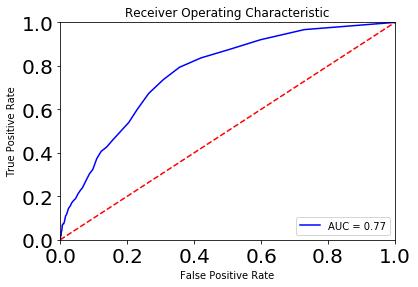

In [112]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [113]:
print(metrics.confusion_matrix(y_test, y_pred))

[[5197    3]
 [ 298    2]]


In [114]:
prediction_stat={}
for i,object_id in enumerate(test_df['id']):
    if isinstance(prediction_type, int):
        prediction_type = [prediction_type]
    #print(i)
    type_no = test_ob.get_object_type_number(object_id)
    
    if type_no not in prediction_stat:
        prediction_stat[type_no] = [0,1]
    else: 
        prediction_stat[type_no][1] = prediction_stat[type_no][1] + 1
    
    if (type_no in prediction_type) & (y_pred[i] ==1):
        prediction_stat[type_no][0]=prediction_stat[type_no][0]+1

    elif (y_pred[i]==0)&(type_no not in prediction_type):
        prediction_stat[type_no][0]=prediction_stat[type_no][0]+1

In [115]:
def ztf_ob_type_name(type_no):
    if type_no == 141:
        return '91BG'
    if type_no == 143:
        return 'Iax'
    if type_no == 145:
        return 'point Ia'
    if type_no == 150:
        return 'KN GW170817'
    if type_no == 151:
        return 'KN Karsen 2017'
    if type_no == 160:
        return 'Superluminous SN'
    if type_no == 161:
        return 'pair instability SN'
    if type_no == 162:
        return 'ILOT'
    if type_no == 163:
        return 'CART'
    if type_no == 164:
        return 'TDE'
    if type_no == 170:
        return 'AGN'
    if (type_no == 180)|(type_no == 181)|(type_no == 183)|(type_no == 190)|(type_no == 191)|(type_no == 192):
        return 'Galactic Trn'
    if type_no == 114:
        return 'MOSFIT-IIn'
    if type_no == 113:
        return 'Core collapse Type II using pca '
    if type_no == 112:
        return 'Core collapse Type II'
    if type_no == 102:
        return 'MOSFIT-Ibc'
    if type_no == 103:
        return 'Core collapse Type Ibc'
    if type_no == 101:
        return 'Ia SN'


In [116]:
x_data_0=[]
hist_0_total = []
hist_0_correct_pred = []

x_data_1=[]
hist_1_total = []
hist_1_correct_pred = []

keys =list(prediction_stat.keys())
keys.sort()
#print(key_details)
for key in keys:
    
    
    if key in prediction_type:
        x_data_1.append(ztf_ob_type_name(key))
        hist_1_correct_pred.append(prediction_stat[key][0])
        hist_1_total.append(prediction_stat[key][1])
    else:
        x_data_0.append(ztf_ob_type_name(key))
        hist_0_correct_pred.append(prediction_stat[key][0])
        hist_0_total.append(prediction_stat[key][1])


In [117]:
from matplotlib.colors import to_rgba

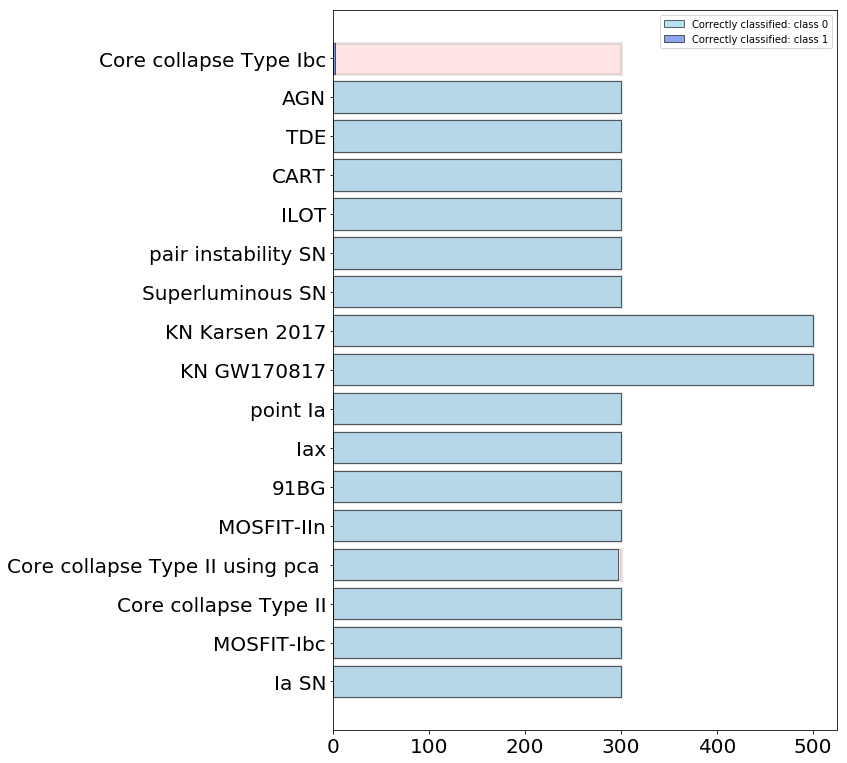

In [118]:
fig = plt.figure(figsize = (7,10))
ax = fig.add_axes([0,0,1,1])
ax.barh(x_data_0,hist_0_total,alpha=.1, color='red',ec='black', linewidth=3)
ax.barh(x_data_0, hist_0_correct_pred , alpha=.6, color='skyblue',ec='black', label='Correctly classified: class 0')
ax.barh(x_data_1,hist_1_total,alpha=.1,color='red',ec='black',linewidth=3)
ax.barh(x_data_1, hist_1_correct_pred , alpha=.6, color='royalblue', ec='black',label='Correctly classified: class 1')
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20)
#for i, v in enumerate(y):
#    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')

plt.legend()
#plt.savefig('important_plots/correct_classifications_plot')
#plt.xticks(rotation=90)
plt.show()